# Task detector v2

### The first version of this task had many issues:
- The model used for the task recognition was not well suited for this. We will now directly use the LSTM decoder to see what is the R2 when trying to predict velocity.
- We need to further explore how each perturbation affects performance of the model to understand the optimal range of perturbations.

### Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import math

# Imports DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import copy


# Imports from other modules and packages in the project
sys.path.append('../')

from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
name = 'Chewie'
date = '1007'
fold = 0
target_variable = 'vel'

In [5]:
dtype = torch.float32

In [23]:
## Load pre-processed data
data_path = '../Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

## 1) Train RNN decoder on Baseline data to predict velocity

#### Get train-val-test split

In [24]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, 
                                        fold, target_variable= target_variable, 
                                        no_outliers = False, force_data = True,
                                        std = False)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


In [25]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models/Models_Force'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [26]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters RNN class
hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)

####### Define model
model_base =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)

#### Train model

In [27]:
train_losses, val_losses = \
    train_model(model_base, 
                xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

Epoch 000 Train 12.3228 Val 12.1863
Epoch 001 Train 11.0875 Val 11.1143
Epoch 002 Train 9.9910 Val 10.0244
Epoch 003 Train 9.0008 Val 9.0627
Epoch 004 Train 8.1100 Val 8.2160
Epoch 005 Train 7.2827 Val 7.4211
Epoch 006 Train 6.5193 Val 6.6434
Epoch 007 Train 5.7878 Val 5.9654
Epoch 008 Train 5.1355 Val 5.3305
Epoch 009 Train 4.5464 Val 4.8295
Epoch 010 Train 4.0024 Val 4.2999
Epoch 011 Train 3.4919 Val 3.9107
Epoch 012 Train 3.0768 Val 3.5448
Epoch 013 Train 2.7140 Val 3.2381
Epoch 014 Train 2.4245 Val 3.0231
Epoch 015 Train 2.1962 Val 2.8357
Epoch 016 Train 2.0073 Val 2.6720
Epoch 017 Train 1.8546 Val 2.5354
Epoch 018 Train 1.7275 Val 2.4078
Epoch 019 Train 1.6243 Val 2.3509
Epoch 020 Train 1.5428 Val 2.2405
Epoch 021 Train 1.4547 Val 2.1742
Epoch 022 Train 1.3844 Val 2.1035
Epoch 023 Train 1.3400 Val 2.0582
Epoch 024 Train 1.3012 Val 2.0184
Epoch 025 Train 1.2748 Val 1.9879
Epoch 026 Train 1.2456 Val 1.9920
Epoch 027 Train 1.2279 Val 1.9621
Epoch 028 Train 1.2083 Val 1.9661
Epoch 029

#### Evaluate model on baseline

In [28]:
y_hat, y_true,\
      train_score, v_score,\
          test_score = eval_model(xx_train_base,
                                   yy_train_base, 
                                   xx_val_base, 
                                   yy_val_base,
                                   xx_test_base, 
                                   yy_test_base, 
                                   model_base, 
                                   metric = 'r2')

Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 


## 2) Test different ratios and std for the simulated data

In [69]:
def remove_neurons(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_removed = int((ratio/100)*num_total_neurons)
    idx_removed = random.sample(list(np.arange(0,num_total_neurons)), num_removed)
    for i in idx_removed:
        sim_data[:,i] = 0
    return sim_data

In [70]:
def shuffle_neurons(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_neurons_to_shuffle = int((ratio/100)*num_total_neurons)
    ind_to_permute = random.sample(list(np.arange(0,num_total_neurons)), num_neurons_to_shuffle)
    ind_to_permute = np.sort(ind_to_permute)
    permuted_indices = np.random.permutation(ind_to_permute)
    for i, new_i in zip(ind_to_permute, permuted_indices):
        sim_data[:,i] = matrix[:,new_i]
    return sim_data

In [71]:
def modify_neurons(matrix, std_gain, std_offset):
    sim_data1 = matrix.copy()
    sim_data2 = matrix.copy()
    
    ### a) Multiplying each column by a random gain from gaussian dist.
    gains = np.random.normal(1, std_gain, size=sim_data1.shape[1])
    # Multiply each column of the matrix by the corresponding gain value
    sim_data1 = sim_data1 * gains[:, np.newaxis].T
    
    ### b) Random offsets
    offsets = np.random.normal(0, std_offset, size=sim_data2.shape[1])
    # Multiply each column of the matrix by the corresponding gain value
    sim_data2 = sim_data2 + offsets[:, np.newaxis].T

    return sim_data1, sim_data2

In [84]:
def add_gain(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_neurons_to_change = int((ratio/100)*num_total_neurons)
    gains = np.random.normal(1, 2, size= num_neurons_to_change)
    ind_to_change = random.sample(list(np.arange(0,num_total_neurons)), num_neurons_to_change)
    for i, gain in zip(ind_to_change, gains):
        sim_data[:,i] = matrix[:,i]*gain
    return sim_data

In [90]:
def add_offset(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_neurons_to_change = int((ratio/100)*num_total_neurons)
    offsets = np.random.normal(0, 25, size= num_neurons_to_change)
    ind_to_change = random.sample(list(np.arange(0,num_total_neurons)), num_neurons_to_change)
    for i, offset in zip(ind_to_change, offsets):
        sim_data[:,i] = matrix[:,i] + offset
    return sim_data

In [91]:
data_matrix = np.vstack(baseline_df['both_rates'])

In [75]:
ratios = np.arange(0,110,10)
v_scores_removed = []
v_scores_shuffled = []

for r in ratios:
  for i in range(10):
      v_scores_removed_i = []
      v_scores_shuffled_i = []
      # First removed neurons
      sim_data = remove_neurons(data_matrix, r)
      baseline_df_sim = baseline_df.copy()
      baseline_df_sim['both_rates'] = sim_data.tolist()
      xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
        xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
            info_test_sim, list_mins_sim, \
              list_maxs_base= get_dataset(baseline_df_sim, 
                                          fold, 
                                          target_variable= target_variable,
                                          no_outliers = False, 
                                          force_data = True, 
                                          std = False)
      y_hat, y_true, train_score,\
        v_score, test_score = eval_model(xx_train_sim, 
                                          yy_train_sim, 
                                          xx_val_sim, 
                                          yy_val_sim,\
                                          xx_test_sim, 
                                          yy_test_sim,
                                          model_base, 
                                          metric = 'r2')
      v_scores_removed_i.append(v_score)

      # Second shuffled neurons
      sim_data = shuffle_neurons(data_matrix, r)
      baseline_df_sim = baseline_df.copy()
      baseline_df_sim['both_rates'] = sim_data.tolist()
      xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
        xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
            info_test_sim, list_mins_sim, \
              list_maxs_base= get_dataset(baseline_df_sim, 
                                          fold, 
                                          target_variable= target_variable,
                                          no_outliers = False, 
                                          force_data = True, 
                                          std = False)
      y_hat, y_true, train_score,\
        v_score, test_score = eval_model(xx_train_sim, 
                                          yy_train_sim, 
                                          xx_val_sim, 
                                          yy_val_sim,\
                                          xx_test_sim, 
                                          yy_test_sim,
                                          model_base, 
                                          metric = 'r2')
      v_scores_shuffled_i.append(v_score)
  v_scores_removed.append(np.median(v_scores_removed_i))
  v_scores_shuffled.append(np.median(v_scores_shuffled_i))
    
    

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train 

In [92]:
ratios = np.arange(0,110,10)

v_scores_gain = []
v_scores_offset = []
for r in ratios :

    for i in range(10):
        v_scores_gain_i = []
        v_scores_offset_i = []
        # First removed neurons
        sim_data1  = add_gain(data_matrix, r)
        baseline_df_sim = baseline_df.copy()
        baseline_df_sim['both_rates'] = sim_data1.tolist()
        xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
          xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
              info_test_sim, list_mins_sim, \
                list_maxs_base= get_dataset(baseline_df_sim, 
                                            fold, 
                                            target_variable= target_variable,
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)
        y_hat, y_true, train_score,\
          v_score, test_score = eval_model(xx_train_sim, 
                                            yy_train_sim, 
                                            xx_val_sim, 
                                            yy_val_sim,\
                                            xx_test_sim, 
                                            yy_test_sim,
                                            model_base, 
                                            metric = 'r2')
        v_scores_gain_i.append(v_score)

        # Second shuffled neurons
        sim_data2 = add_offset(data_matrix, r)
        baseline_df_sim = baseline_df.copy()
        baseline_df_sim['both_rates'] = sim_data2.tolist()
        xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
          xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
              info_test_sim, list_mins_sim, \
                list_maxs_base= get_dataset(baseline_df_sim, 
                                            fold, 
                                            target_variable= target_variable,
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)
        y_hat, y_true, train_score,\
          v_score, test_score = eval_model(xx_train_sim, 
                                            yy_train_sim, 
                                            xx_val_sim, 
                                            yy_val_sim,\
                                            xx_test_sim, 
                                            yy_test_sim,
                                            model_base, 
                                            metric = 'r2')
        v_scores_offset_i.append(v_score)

    v_scores_gain.append(np.median(v_scores_gain_i))
    v_scores_offset.append(np.median(v_scores_offset_i))

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train 

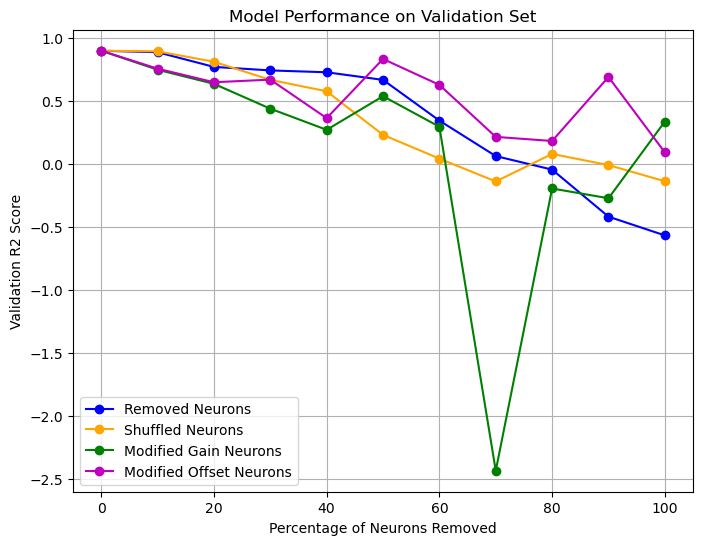

In [93]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(ratios, v_scores_removed, marker='o', color='b', linestyle='-', label = 'Removed Neurons')
plt.plot(ratios, v_scores_shuffled, marker='o', color='orange', linestyle='-', label = 'Shuffled Neurons')
plt.plot(ratios, v_scores_gain, marker='o', color='g', linestyle='-', label = 'Modified Gain Neurons')
plt.plot(ratios, v_scores_offset, marker='o', color='m', linestyle='-', label = 'Modified Offset Neurons')

# Add labels and title
plt.xlabel('Percentage of Neurons Removed')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()

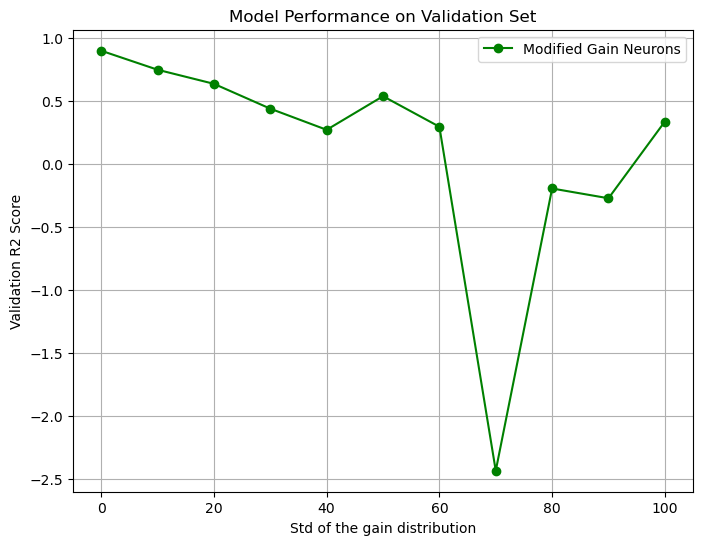

In [94]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(ratios, v_scores_gain, marker='o', color='g', linestyle='-', label = 'Modified Gain Neurons')

# Add labels and title
plt.xlabel('Std of the gain distribution')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()

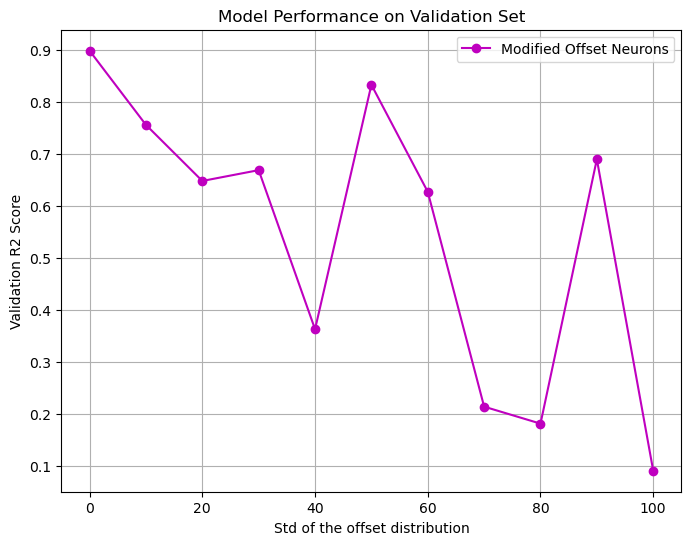

In [95]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(ratios, v_scores_offset, marker='o', color='m', linestyle='-', label = 'Modified Offset Neurons')

# Add labels and title
plt.xlabel('Std of the offset distribution')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()


__Conclusion__:
- Single perturbations (removing neurons, shuffling neurons, adding gain or offset) for a performance of less than 60% R2 need to be:
    - 30% shufled neurons
    - 60% "removed" neurons
    - 0.7std for gain distribution with mean 1
    - 16-18 std for aoofset distribution with mean 0

We can now either consider each perturbation a single task or mix them and create different datasets.

## 3) Test algorithm with 1 of the previous perturbations
`Reminder algorithm:`

#### The following part of the code should correspond to this logic/algorithm structure:

**Initialize with first task (~pretraining):**
- 1- Load Baseline Data and set task_id to 0, and max_id to 0 too
- 2- Train TaskDetectorRNN on Baseline Data
- 3- Compute R2 and define threshold
- 4- Create folder to save trained task detector models and save it with the name of the task (here 0)
- 5- Train hnet using task_id = 0.

**Continue with new data (could be the same task):**
- 6- Load new data
- 7- For each of the previous tasks test the trained TaskDetectorRNN and compute the R2 score. Save in a list all R2 scores.
    - if max(r2_list) > thrs: get argmax of the list as the task_id
        - use h_net with the task_id corresponding to the data.
        - report results (R2,...)
    - else:
        - max_id += 1
        - task_id = max_id
        - train TaskDetectorRNN on new data and save it with its task_id
        - check R2 > threshold --> else report ERROR.
        - train h_net using this task_id.
        - report results (R2,...)

In [29]:
def save_model(model, task_id, folder):
    # Define the directory path
    models_dir = "../Models"
    task_models_dir = os.path.join(models_dir, folder)

    # Check if the directory exists, if not, create it
    if not os.path.exists(task_models_dir):
        os.makedirs(task_models_dir)

    # Define the file name
    model_file_name = f"Model_Task_{task_id}.pth"  # Use .pth extension for PyTorch models

    # Save the model
    model_path = os.path.join(task_models_dir, model_file_name)

    # Save the model using torch.save
    torch.save(model, model_path)


In [30]:
task_id = 0

In [31]:
task_detector = copy.deepcopy(model_base).to(device)
# Save the trained model
save_model(task_detector, task_id, "Models_Task_Recognition")

In [32]:
y_hat, y_true,\
      train_score, v_score,\
          test_score = eval_model(xx_train_base,
                                   yy_train_base, 
                                   xx_val_base, 
                                   yy_val_base,
                                   xx_test_base, 
                                   yy_test_base, 
                                   task_detector, 
                                   metric = 'r2')
r2_max = v_score
thrs = 0.90*r2_max
print('The threshold to belong to task 0 is an R2 of : ', thrs)

Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
The threshold to belong to task 0 is an R2 of :  0.8088168012501975


### 3.1- Train hypernetwork on task 0

In [48]:

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

# Hyperparameters LSTM class (from force model without hnet)
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

lr = 0.001
beta = 1e-1


torch.manual_seed(42)

In [30]:
from hypnettorch.hnets import HyperNetInterface
from hypnettorch.hnets import HMLP

In [31]:

#### Defining the template, main and hnet models and initializing them
template_m = Causal_Simple_RNN(num_features=num_features, 
                    hidden_units= n_hidden_units, 
                    num_layers = num_layers, 
                    out_dims = num_dim_output, ).to(device)

param_shapes = [p.shape for p in list(template_m.parameters())]

num_conditions = 60 # we want more possible conditions than what we can reach
size_task_embedding = 8 #to check if the best one

hnet = HMLP(param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[13], 
            num_cond_embs=num_conditions).to(device)

for param in hnet.parameters():
    param.requires_grad = True

w_test = hnet(cond_id = 0)

LSTM_ = False

model = RNN_Main_Model(num_features= num_features, hnet_output = w_test,  hidden_size = n_hidden_units,
                            num_layers= num_layers,out_dims=num_dim_output,  
                            dropout= dropout,  LSTM_ = LSTM_).to(device)

for param in model.parameters():
    param.requires_grad = False

    
#### Apply initialization to the hnet following the recommendations of hypnettorch
hnet.apply_hyperfan_init()
#### Training the hnet for the 1st task
print('Task id: ', task_id)

calc_reg = False 

if task_id >0:
    calc_reg = True

# Set up the optimizer with the specified learning rate
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

# Set up a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, 
                                step_size=lr_step_size, 
                                gamma=lr_gamma)

train_losses_, val_losses_, best_w_ =train_current_task(
        model, 
        hnet,
        yy_train_base, 
        xx_train_base,
        yy_val_base,
        xx_val_base,
        optimizer,
        scheduler,
        calc_reg = calc_reg,
        cond_id = task_id,
        lr=lr,
        lr_step_size=5,
        lr_gamma= lr_gamma, #0.9
        sequence_length_LSTM = seq_length_LSTM, #15
        batch_size_train = batch_size_train, #15
        batch_size_val = batch_size_train, #15
        num_epochs=1000, 
        delta = 8,
        beta = beta,             
        regularizer=reg_hnet,
        l1_ratio = l1_ratio_reg, #0.5
        alpha = alpha_reg,    
        early_stop = 5,
        chunks = False)

Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Task id:  0
Epoch 000 Train 3.8105 Val 3.2040
Epoch 001 Train 2.5091 Val 3.3716
Epoch 002 Train 2.4014 Val 3.3517
Epoch 003 Train 2.2979 Val 3.1987
Epoch 004 Train 2.1621 Val 3.2076
Epoch 005 Train 2.0937 Val 3.2689
Epoch 006 Train 1.9951 Val 3.2047
Epoch 007 Train 1.9900 Val 3.2057
Epoch 008 Train 1.9346 Val 3.1263
Epoch 009 Train 1.9133 Val 3.2622
Epoch 010 Train 2.1341 Val 3.4588
Epoch 011 Train 2.1126 Val 3.2608
Epoch 012 Train 2.1290 Val 3.4503
Epoch 013 Train 2.0771 Val 3.4066
Epoch 014 Train 1.9997 Val 3.2761
Decrease LR
Epoch 015 Train 1.9815 Val 3.1912
Epoch 016 Train 1.8171 Val 3.1841
Epoch 017 Train 1.7732 Val 3.0781
Epoch 018 Train 1.7150 Val 3.0739
Epoch 019 Train 1.6875 Val 3.1241
Epoch 020 Train 1.7299 Val 3.1377
Epoch 021 Train 

In [33]:
W_0 = hnet(cond_id = 0)
r2 = calc_explained_variance_mnet(xx_val_base, yy_val_base, W_0, model)
print('R2 for the task', task_id, ' is ', r2)
# Save the trained model
save_model(hnet, task_id, "HNET_Task_Recog")

R2 for the task 0  is  0.8165038526058197


In [40]:
data_dict_test = {}
data_dict_test['Task_0'] = [xx_test_base, yy_test_base]

### 3.2- Loop over any new task
#### Start only using one extra task and see if it works

- 6- Load new data
- 7- For each of the previous tasks test the trained TaskDetectorRNN and compute the R2 score. Save in a list all R2 scores.
    - if max(r2_list) > thrs: get argmax of the list as the task_id
        - use h_net with the task_id corresponding to the data.
        - report results (R2,...)
    - else:
        - max_id += 1
        - task_id = max_id
        - train TaskDetectorRNN on new data and save it with its task_id
        - check R2 > threshold --> else report ERROR.
        - train h_net using this task_id.
        - report results (R2,...)

#### We first start trying only on one other task, in this case we perturb the dataset by removing neurons (replacing the columns by 0) up to 50% of the neurons in the dataset.


In [33]:
import copy

# Loading data
sim_data = remove_neurons(data_matrix, 50)
baseline_df_sim = baseline_df.copy()
baseline_df_sim['both_rates'] = sim_data.tolist()
new_data = baseline_df_sim

x_train_1, y_train_1, x_val_1, y_val_1,\
      x_test_1, y_test_1, info_train, info_val,\
          info_test, list_mins_base, \
            list_maxs_base= get_dataset(new_data, 
                                            fold, 
                                            target_variable= target_variable, 
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)

path_recog_models = '../Models/Models_Task_Recognition'
r2_list = []

trained_detectors = np.sort(os.listdir(path_recog_models))
max_id = len(trained_detectors) - 1

for i,m in enumerate(trained_detectors):
    print(m)
    model_i = torch.load(os.path.join(path_recog_models, m)).to(device)
    model_i.eval()
    dtype = torch.float32
    _, _, _, r2_i,_ = eval_model(x_train_1, 
                                y_train_1, 
                                x_val_1, 
                                y_val_1,
                                x_test_1, 
                                y_test_1,
                                model_i, 
                                metric = 'r2')
    r2_list.append(r2_i)


print('Max_id is ', max_id)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Model_Task_0.pth
Train R2: 0.64 
Val R2: 0.67 
Test R2: 0.53 
Model_Task_1.pth
Train R2: 0.94 
Val R2: 0.87 
Test R2: 0.85 
Model_Task_2.pth
Train R2: 0.47 
Val R2: 0.39 
Test R2: 0.46 
Max_id is  2


#### Here we can use the latest trained hnet

In [39]:
path_hnet_models = '../Models/HNET_Task_Recog'
trained_hnet = np.sort(os.listdir(path_hnet_models))[-1]
hnet = torch.load(os.path.join(path_hnet_models,trained_hnet)).to(device)

In [45]:
w_test = hnet(cond_id = 0)

In [50]:
model = RNN_Main_Model(num_features= num_features, hnet_output = w_test,  hidden_size = n_hidden_units,
                            num_layers= num_layers,out_dims=num_dim_output,  
                            dropout= dropout,  LSTM_ = False).to(device)

for param in model.parameters():
    param.requires_grad = False

In [51]:
max_r2 = max(r2_list)
if max_r2 > thrs:
    print('This data comes from a known task. ')
    task_id = np.argmax(r2_list)
    print('Task_id for this task is ', task_id)
    W_i = hnet(cond_id = int(task_id))
    r2 = calc_explained_variance_mnet(x_val_1, y_val_1, W_i, model)
    print('R2 for the HNET on task', task_id, ' is ', r2)
else:
    print('This data comes from a different task !')
    max_id += 1
    print('Mx id has changed to ', max_id)
    task_id = max_id
    print('Task_id for this task is ', task_id)
    model_task_1 =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)
    dtype = torch.float32
    train_losses, val_losses = \
    train_model(model_task_1, 
                x_train_1, 
                y_train_1, 
                x_val_1, 
                y_val_1,
                lr=  0.00001,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

    # Save the trained model
    save_model(model_task_1, task_id, "Models_Task_Recognition")

    # Evaluate the model and set a threshold
    _, _, _, r2_i,_ = eval_model(x_train_1, 
                                y_train_1, 
                                x_val_1, 
                                y_val_1,
                                x_test_1, 
                                y_test_1,
                                model_task_1, 
                                metric = 'r2')

    print('R2 for the task', task_id, ' is ', r2_i)

    if r2_i <thrs:
        print('ERROR, THE TASK COULD NOT BE LEARNED BY THE DETECTOR')
        
        #break

    else:
        print('Task learned without issues.')

    print('Current task id is ',task_id)

    if task_id >0:
        calc_reg = True

    train_losses_, val_losses_, best_w_ =train_current_task(
            model, 
            hnet,
            y_train_1, 
            x_train_1, 
            y_val_1,
            x_val_1, 
            optimizer,
            scheduler,
            calc_reg = calc_reg,
            cond_id = int(task_id),
            lr=lr,
            lr_step_size=5,
            lr_gamma= lr_gamma, #0.9
            sequence_length_LSTM = seq_length_LSTM, #15
            batch_size_train = batch_size_train, #15
            batch_size_val = batch_size_train, #15
            num_epochs=1000, 
            delta = 8,
            beta = beta,             
            regularizer=reg_hnet,
            l1_ratio = l1_ratio_reg, #0.5
            alpha = alpha_reg,    
            early_stop = 5,
            chunks = False)
    for cond in range(0, task_id):
        W_i = hnet(cond_id = cond)
        data = data_dict_test['Task_'+str(cond)]
        r2 = calc_explained_variance_mnet(data[0], data[1], W_i, model)
        print('R2 for the HNET on Task ', cond, ' is ', r2)
    data_dict_test['Task_'+str(task_id)] = [x_test_1, y_test_1]
    data = data_dict_test['Task_'+str(task_id)]
    W_id = hnet(cond_id = task_id)
    r2 = calc_explained_variance_mnet(data[0], data[1], W_id, model)
    print('R2 for the HNET on Task ', task_id, ' is ', r2)
    # Save the trained model
    save_model(hnet, task_id, "HNET_Task_Recog")

This data comes from a known task. 
Task_id for this task is  1
R2 for the HNET on task 1  is  0.8201481401920319


### Try now to add a task 2

In [52]:
sim_data2 = shuffle_neurons(data_matrix, 55)
baseline_df_sim = baseline_df.copy()
baseline_df_sim['both_rates'] = sim_data2.tolist()
new_data2 = baseline_df_sim

In [60]:
x_train_2, y_train_2, x_val_2, y_val_2,\
      x_test_2, y_test_2, info_train, info_val,\
          info_test, list_mins_base, \
            list_maxs_base= get_dataset(new_data2, 
                                            fold, 
                                            target_variable= target_variable, 
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)

path_recog_models = '../Models/Models_Task_Recognition'
r2_list = []

trained_detectors = np.sort(os.listdir(path_recog_models))
max_id = len(trained_detectors) - 1


for i,m in enumerate(trained_detectors):
    print(m)
    model_i = torch.load(os.path.join(path_recog_models, m)).to(device)
    model_i.eval()
    dtype = torch.float32
    _, _, _, r2_i,_ = eval_model(x_train_2, 
                                y_train_2, 
                                x_val_2, 
                                y_val_2,
                                x_test_2,
                                y_test_2,
                                model_i, 
                                metric = 'r2')
    r2_list.append(r2_i)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Model_Task_0.pth
Train R2: 0.17 
Val R2: 0.14 
Test R2: 0.19 
Model_Task_1.pth
Train R2: 0.42 
Val R2: 0.36 
Test R2: 0.36 


In [61]:
# Set up the optimizer with the specified learning rate
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

# Set up a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, 
                                step_size=lr_step_size, 
                                gamma=lr_gamma)

In [62]:
max_r2 = max(r2_list)
if max_r2 > thrs:
    print('This data comes from a known task. ')
    task_id = np.argmax(r2_list)
    print('Task_id for this task is ', task_id)
    W_i = hnet(cond_id = int(task_id))
    r2 = calc_explained_variance_mnet(x_val_2, y_val_2, W_i, model)
    print('R2 for the HNET on task', task_id, ' is ', r2)
else:
    print('This data comes from a different task !')
    max_id += 1
    print('Mx id has changed to ', max_id)
    task_id = max_id
    print('Task_id for this task is ', task_id)
    model_task_2 =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)
    dtype = torch.float32
    train_losses, val_losses = \
    train_model(model_task_2, 
                x_train_2, 
                y_train_2, 
                x_val_2, 
                y_val_2,
                lr=  0.00001,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

    # Save the trained model
    save_model(model_task_2, task_id, "Models_Task_Recognition")

    # Evaluate the model and set a threshold
    _, _, _, r2_i,_ = eval_model(x_train_2, 
                                y_train_2, 
                                x_val_2, 
                                y_val_2,
                                x_test_2, 
                                y_test_2,
                                model_task_2, 
                                metric = 'r2')

    print('R2 for the task', task_id, ' is ', r2_i)

    if r2_i <thrs:
        print('ERROR, THE TASK COULD NOT BE LEARNED BY THE DETECTOR')
        
        #break

    else:
        print('Task learned without issues.')

        print('Current task id is ',task_id)

        if task_id >0:
            calc_reg = True

        train_losses_, val_losses_, best_w_ =train_current_task(
                model, 
                hnet,
                y_train_2, 
                x_train_2, 
                y_val_2,
                x_val_2, 
                optimizer,
                scheduler,
                calc_reg = calc_reg,
                cond_id = int(task_id),
                lr=lr,
                lr_step_size=5,
                lr_gamma= lr_gamma, #0.9
                sequence_length_LSTM = seq_length_LSTM, #15
                batch_size_train = batch_size_train, #15
                batch_size_val = batch_size_train, #15
                num_epochs=1000, 
                delta = 8,
                beta = beta,             
                regularizer=reg_hnet,
                l1_ratio = l1_ratio_reg, #0.5
                alpha = alpha_reg,    
                early_stop = 5,
                chunks = False)
        
        for cond in range(0, task_id):
            W_i = hnet(cond_id = cond)
            data = data_dict_test['Task_'+str(cond)]
            r2 = calc_explained_variance_mnet(data[0], data[1], W_i, model)
            print('R2 for the HNET on Task ', cond, ' is ', r2)


        data_dict_test['Task_'+str(task_id)] = [x_test_2, y_test_2]
        data = data_dict_test['Task_'+str(task_id)]
        W_id = hnet(cond_id = task_id)
        r2 = calc_explained_variance_mnet(data[0], data[1], W_id, model)
        print('R2 for the HNET on Task ', task_id, ' is ', r2)
        # Save the trained model
        save_model(hnet, task_id, "HNET_Task_Recog")

This data comes from a different task !
Mx id has changed to  2
Task_id for this task is  2
Epoch 000 Train 12.4127 Val 12.1801
Epoch 001 Train 11.1708 Val 11.0643
Epoch 002 Train 10.0720 Val 9.9628
Epoch 003 Train 9.0024 Val 8.9697
Epoch 004 Train 8.0783 Val 8.1211
Epoch 005 Train 7.2535 Val 7.3553
Epoch 006 Train 6.5112 Val 6.6416
Epoch 007 Train 5.8104 Val 6.0029
Epoch 008 Train 5.1665 Val 5.3871
Epoch 009 Train 4.5614 Val 4.8517
Epoch 010 Train 3.9758 Val 4.2498
Epoch 011 Train 3.4252 Val 3.8330
Epoch 012 Train 3.0205 Val 3.5091
Epoch 013 Train 2.6835 Val 3.2392
Epoch 014 Train 2.4050 Val 3.0225
Epoch 015 Train 2.1775 Val 2.8529
Epoch 016 Train 2.0035 Val 2.6992
Epoch 017 Train 1.8523 Val 2.5619
Epoch 018 Train 1.7293 Val 2.4292
Epoch 019 Train 1.6331 Val 2.3991
Epoch 020 Train 1.5442 Val 2.3575
Epoch 021 Train 1.4623 Val 2.1873
Epoch 022 Train 1.3962 Val 2.1723
Epoch 023 Train 1.3509 Val 2.1283
Epoch 024 Train 1.3142 Val 2.1424
Epoch 025 Train 1.2900 Val 2.0668
Epoch 026 Train 1.2

NameError: name 'data_dict_test' is not defined

### Adding task 3

In [98]:
sim_data3 = add_gain(data_matrix,40)
baseline_df_sim = baseline_df.copy()
baseline_df_sim['both_rates'] = sim_data3.tolist()
new_data3 = baseline_df_sim

In [99]:
x_train_3, y_train_3, x_val_3, y_val_3,\
      x_test_3, y_test_3, info_train, info_val,\
          info_test, list_mins_base, \
            list_maxs_base= get_dataset(new_data3, 
                                            fold, 
                                            target_variable= target_variable, 
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)

path_recog_models = '../Models/Models_Task_Recognition'
r2_list = []

trained_detectors = np.sort(os.listdir(path_recog_models))
max_id = len(trained_detectors) - 1


for i,m in enumerate(trained_detectors):
    print(m)
    model_i = torch.load(os.path.join(path_recog_models, m)).to(device)
    model_i.eval()
    dtype = torch.float32
    _, _, _, r2_i,_ = eval_model(x_train_3, 
                                y_train_3, 
                                x_val_3, 
                                y_val_3,
                                x_test_3,
                                y_test_3,
                                model_i, 
                                metric = 'r2')
    r2_list.append(r2_i)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Model_Task_0.pth
Train R2: 0.48 
Val R2: 0.46 
Test R2: 0.37 
Model_Task_1.pth
Train R2: 0.65 
Val R2: 0.59 
Test R2: 0.46 
Model_Task_2.pth
Train R2: -0.10 
Val R2: -0.16 
Test R2: -0.13 


In [100]:
max_r2 = max(r2_list)
if max_r2 > thrs:
    print('This data comes from a known task. ')
    task_id = np.argmax(r2_list)
    print('Task_id for this task is ', task_id)
    W_i = hnet(cond_id = int(task_id))
    r2 = calc_explained_variance_mnet(x_val_3, y_val_3, W_i, model)
    print('R2 for the HNET on task', task_id, ' is ', r2)
else:
    print('This data comes from a different task !')
    max_id += 1
    print('Mx id has changed to ', max_id)
    task_id = max_id
    print('Task_id for this task is ', task_id)
    model_task_3 =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)
    dtype = torch.float32
    train_losses, val_losses = \
    train_model(model_task_3, 
                x_train_3, 
                y_train_3, 
                x_val_3, 
                y_val_3,
                lr=  0.00001,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

    # Save the trained model
    save_model(model_task_3, task_id, "Models_Task_Recognition")

    # Evaluate the model and set a threshold
    _, _, _, r2_i,_ = eval_model(x_train_3, 
                                y_train_3, 
                                x_val_3, 
                                y_val_3,
                                x_test_3, 
                                y_test_3,
                                model_task_3, 
                                metric = 'r2')

    print('R2 for the task', task_id, ' is ', r2_i)

    if r2_i <thrs:
        print('ERROR, THE TASK COULD NOT BE LEARNED BY THE DETECTOR')
        
        #break

    else:
        print('Task learned without issues.')

        print('Current task id is ',task_id)

        if task_id >0:
            calc_reg = True

        train_losses_, val_losses_, best_w_ =train_current_task(
                model, 
                hnet,
                y_train_3, 
                x_train_3, 
                y_val_3,
                x_val_3, 
                optimizer,
                scheduler,
                calc_reg = calc_reg,
                cond_id = int(task_id),
                lr=lr,
                lr_step_size=5,
                lr_gamma= lr_gamma, #0.9
                sequence_length_LSTM = seq_length_LSTM, #15
                batch_size_train = batch_size_train, #15
                batch_size_val = batch_size_train, #15
                num_epochs=1000, 
                delta = 8,
                beta = beta,             
                regularizer=reg_hnet,
                l1_ratio = l1_ratio_reg, #0.5
                alpha = alpha_reg,    
                early_stop = 5,
                chunks = False)
        
        for cond in range(0, task_id):
            W_i = hnet(cond_id = cond)
            data = data_dict_test['Task_'+str(cond)]
            r2 = calc_explained_variance_mnet(data[0], data[1], W_i, model)
            print('R2 for the HNET on Task ', cond, ' is ', r2)


        data_dict_test['Task_'+str(task_id)] = [x_test_3, y_test_3]
        data = data_dict_test['Task_'+str(task_id)]
        W_id = hnet(cond_id = task_id)
        r2 = calc_explained_variance_mnet(data[0], data[1], W_id, model)
        print('R2 for the HNET on Task ', task_id, ' is ', r2)
        # Save the trained model
        save_model(hnet, task_id, "HNET_Task_Recog")

This data comes from a different task !
Mx id has changed to  3
Task_id for this task is  3
Epoch 000 Train 12.4263 Val 12.4055
Epoch 001 Train 11.4180 Val 11.5020
Epoch 002 Train 10.5348 Val 10.6799
Epoch 003 Train 9.6608 Val 9.8546
Epoch 004 Train 8.8210 Val 9.0595
Epoch 005 Train 8.0103 Val 8.2973
Epoch 006 Train 7.2545 Val 7.5754
Epoch 007 Train 6.5712 Val 6.8677
Epoch 008 Train 5.9565 Val 6.2792
Epoch 009 Train 5.3925 Val 5.7659
Epoch 010 Train 4.8020 Val 5.1253
Epoch 011 Train 4.1956 Val 4.5467
Epoch 012 Train 3.6737 Val 4.0897
Epoch 013 Train 3.2276 Val 3.7022
Epoch 014 Train 2.8587 Val 3.4264
Epoch 015 Train 2.5547 Val 3.1346
Epoch 016 Train 2.3016 Val 2.9334
Epoch 017 Train 2.0918 Val 2.7873
Epoch 018 Train 1.9258 Val 2.6312
Epoch 019 Train 1.7882 Val 2.5550
Epoch 020 Train 1.6663 Val 2.4528
Epoch 021 Train 1.5532 Val 2.3646
Epoch 022 Train 1.4670 Val 2.2904
Epoch 023 Train 1.3991 Val 2.2250
Epoch 024 Train 1.3505 Val 2.1900
Epoch 025 Train 1.3118 Val 2.1815
Epoch 026 Train 1.

KeyError: 'Task_1'

In [114]:
data_dict_test = {}
data_dict_test['Task_0'] = [xx_test_base, yy_test_base]
data_dict_test['Task_1'] = [x_test_1, y_test_1]
data_dict_test['Task_2'] = [x_test_2, y_test_2]
data_dict_test['Task_3'] = [x_test_3, y_test_3]

In [115]:
for cond in range(0, task_id):
    W_i = hnet(cond_id = cond)
    data = data_dict_test['Task_'+str(cond)]
    r2 = calc_explained_variance_mnet(data[0], data[1], W_i, model)
    print('R2 for the HNET on Task ', cond, ' is ', r2)

R2 for the HNET on Task  0  is  0.8040171265602112
R2 for the HNET on Task  1  is  0.7469780147075653
R2 for the HNET on Task  2  is  0.8293254375457764


### Adding offset data

In [117]:
sim_data4 = add_gain(data_matrix,40)
baseline_df_sim = baseline_df.copy()
baseline_df_sim['both_rates'] = sim_data4.tolist()
new_data4 = baseline_df_sim

In [118]:
x_train_4, y_train_4, x_val_4, y_val_4,\
      x_test_4, y_test_4, info_train, info_val,\
          info_test, list_mins_base, \
            list_maxs_base= get_dataset(new_data4, 
                                            fold, 
                                            target_variable= target_variable, 
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)

path_recog_models = '../Models/Models_Task_Recognition'
r2_list = []

trained_detectors = np.sort(os.listdir(path_recog_models))
max_id = len(trained_detectors) - 1


for i,m in enumerate(trained_detectors):
    print(m)
    model_i = torch.load(os.path.join(path_recog_models, m)).to(device)
    model_i.eval()
    dtype = torch.float32
    _, _, _, r2_i,_ = eval_model(x_train_4, 
                                y_train_4, 
                                x_val_4, 
                                y_val_4,
                                x_test_4,
                                y_test_4,
                                model_i, 
                                metric = 'r2')
    r2_list.append(r2_i)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Model_Task_0.pth
Train R2: 0.71 
Val R2: 0.64 
Test R2: 0.60 
Model_Task_1.pth
Train R2: 0.41 
Val R2: 0.33 
Test R2: 0.21 
Model_Task_2.pth
Train R2: -0.15 
Val R2: -0.18 
Test R2: -0.32 
Model_Task_3.pth
Train R2: 0.42 
Val R2: 0.38 
Test R2: 0.19 


In [119]:
max_r2 = max(r2_list)
if max_r2 > thrs:
    print('This data comes from a known task. ')
    task_id = np.argmax(r2_list)
    print('Task_id for this task is ', task_id)
    W_i = hnet(cond_id = int(task_id))
    r2 = calc_explained_variance_mnet(x_val_4, y_val_4, W_i, model)
    print('R2 for the HNET on task', task_id, ' is ', r2)
else:
    print('This data comes from a different task !')
    max_id += 1
    print('Mx id has changed to ', max_id)
    task_id = max_id
    print('Task_id for this task is ', task_id)
    model_task_4 =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)
    dtype = torch.float32
    train_losses, val_losses = \
    train_model(model_task_4, 
                x_train_4, 
                y_train_4, 
                x_val_4, 
                y_val_4,
                lr=  0.00001,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

    # Save the trained model
    save_model(model_task_4, task_id, "Models_Task_Recognition")

    # Evaluate the model and set a threshold
    _, _, _, r2_i,_ = eval_model(x_train_4, 
                                y_train_4, 
                                x_val_4, 
                                y_val_4,
                                x_test_4, 
                                y_test_4,
                                model_task_4, 
                                metric = 'r2')

    print('R2 for the task', task_id, ' is ', r2_i)

    if r2_i <thrs:
        print('ERROR, THE TASK COULD NOT BE LEARNED BY THE DETECTOR')
        
        #break

    else:
        print('Task learned without issues.')

        print('Current task id is ',task_id)

        if task_id >0:
            calc_reg = True

        train_losses_, val_losses_, best_w_ =train_current_task(
                model, 
                hnet,
                y_train_4, 
                x_train_4, 
                y_val_4,
                x_val_4, 
                optimizer,
                scheduler,
                calc_reg = calc_reg,
                cond_id = int(task_id),
                lr=lr,
                lr_step_size=5,
                lr_gamma= lr_gamma, #0.9
                sequence_length_LSTM = seq_length_LSTM, #15
                batch_size_train = batch_size_train, #15
                batch_size_val = batch_size_train, #15
                num_epochs=1000, 
                delta = 8,
                beta = beta,             
                regularizer=reg_hnet,
                l1_ratio = l1_ratio_reg, #0.5
                alpha = alpha_reg,    
                early_stop = 5,
                chunks = False)
        
        for cond in range(0, task_id):
            W_i = hnet(cond_id = cond)
            data = data_dict_test['Task_'+str(cond)]
            r2 = calc_explained_variance_mnet(data[0], data[1], W_i, model)
            print('R2 for the HNET on Task ', cond, ' is ', r2)


        data_dict_test['Task_'+str(task_id)] = [x_test_4, y_test_4]
        data = data_dict_test['Task_'+str(task_id)]
        W_id = hnet(cond_id = task_id)
        r2 = calc_explained_variance_mnet(data[0], data[1], W_id, model)
        print('R2 for the HNET on Task ', task_id, ' is ', r2)
        # Save the trained model
        save_model(hnet, task_id, "HNET_Task_Recog")

This data comes from a different task !
Mx id has changed to  4
Task_id for this task is  4
Epoch 000 Train 12.4396 Val 12.5267
Epoch 001 Train 11.4184 Val 11.7766
Epoch 002 Train 10.6288 Val 11.0495
Epoch 003 Train 9.8721 Val 10.2862
Epoch 004 Train 9.1132 Val 9.5117
Epoch 005 Train 8.3567 Val 8.7335
Epoch 006 Train 7.6216 Val 8.0093
Epoch 007 Train 6.9004 Val 7.2914
Epoch 008 Train 6.2358 Val 6.6458
Epoch 009 Train 5.6309 Val 6.0740
Epoch 010 Train 4.9880 Val 5.4008
Epoch 011 Train 4.3327 Val 4.8064
Epoch 012 Train 3.7667 Val 4.3103
Epoch 013 Train 3.3036 Val 3.9233
Epoch 014 Train 2.9181 Val 3.6170
Epoch 015 Train 2.6013 Val 3.3672
Epoch 016 Train 2.3450 Val 3.1507
Epoch 017 Train 2.1406 Val 2.9981
Epoch 018 Train 1.9679 Val 2.8443
Epoch 019 Train 1.8246 Val 2.7248
Epoch 020 Train 1.7027 Val 2.5756
Epoch 021 Train 1.5848 Val 2.4829
Epoch 022 Train 1.4999 Val 2.4042
Epoch 023 Train 1.4300 Val 2.3566
Epoch 024 Train 1.3808 Val 2.3130
Epoch 025 Train 1.3431 Val 2.2641
Epoch 026 Train 1

In [120]:
data_dir = "../Data"
path_to_save_data = os.path.join(data_dir, 'Processed_Data', 'Test_Data_Detector_'+name+'_'+str(date)+'.pkl')

# Pickle the data and save it to file
with open(path_to_save_data, 'wb') as handle:
    pickle.dump(data_dict_test, handle, protocol=4)

In [ ]:
results_task_detector = 